In [1]:
import operator
import math
import random
import matplotlib.pyplot as plt

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [2]:
# Define new functions
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
pset.renameArguments(ARG0='x')

In [3]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [4]:
def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    sqerrors = ((func(x) - x**4 - x**3 - x**2 - x)**2 for x in points)
    return math.fsum(sqerrors) / len(points),

In [5]:
toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-10,10)])
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [6]:
def main():
    random.seed(318)

    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)
    
    pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 1000, stats=mstats,
                                   halloffame=hof, verbose=False)
    
    return pop, log, hof

In [7]:
def plot(original_function, candidate_function):
        
        x_values = [x/10. for x in range(-10,10)]
        
        print(x_values)
        
        original_points = []
        candidate_points = []
        
        for value in x_values:
            original_points.append(original_function(value))
            candidate_points.append(candidate_function(value))
        
        plt.plot(x_values, original_points, 'k', x_values, candidate_points, 'r')
        plt.show()

add(mul(add(x, sin(sin(add(add(x, add(mul(add(x, sin(add(mul(sin(sin(x)), x), sin(sin(sin(x)))))), x), sin(-1))), -1)))), sub(add(x, 1), cos(0))), add(x, sin(x)))
[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


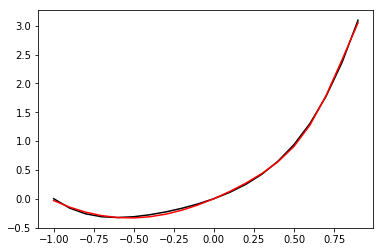

In [8]:
if __name__ == "__main__":
    results = main()
    
    expr = results[2][0]
    
    print(expr)
    
    
    # PLOTANDO OS GRAFICOS
    tree = gp.PrimitiveTree(expr)
    
    candidate_function = toolbox.compile(tree)
    

    original_function = lambda x: x**4 + x**3 + x**2 + x
    
    
    plot(original_function, candidate_function)
    